In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random
data_path = pathlib.Path('../IMAGE')

In [2]:
all_image_paths = list(data_path.glob('*/*/*.png'))  
all_image_paths = [str(path) for path in all_image_paths]
image_count = len(all_image_paths)
random.shuffle(all_image_paths)

In [3]:
label_names = sorted(item.name for item in data_path.glob('./*/*') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

In [4]:
print(label_names)
print(label_to_index)
for image, label in zip(all_image_paths[:5], all_image_labels[:5]):
    print(image, ' --->  ', label)

['Air Force 1', 'Air VaporMax Plus', 'Jordan_13RetroChineseNewYear', 'Jordan_AirJordan1Mid', 'Jordan_AirJordan6TravisScott', 'LebronXviI Promise', 'Orginals', 'Originals', 'PUMA RUBIK COLOR', 'UltraBoost', 'puma_catrgoy', 'yeezy']
{'Air Force 1': 0, 'Air VaporMax Plus': 1, 'Jordan_13RetroChineseNewYear': 2, 'Jordan_AirJordan1Mid': 3, 'Jordan_AirJordan6TravisScott': 4, 'LebronXviI Promise': 5, 'Orginals': 6, 'Originals': 7, 'PUMA RUBIK COLOR': 8, 'UltraBoost': 9, 'puma_catrgoy': 10, 'yeezy': 11}
..\IMAGE\Puma\puma_catrgoy\puma_catogry16.png  --->   10
..\IMAGE\Jordan\Jordan_13RetroChineseNewYear\Jordan_13RetroChineseNewYear5.png  --->   2
..\IMAGE\Adidas\UltraBoost\Adidas_UltraBoost2.png  --->   9
..\IMAGE\Jordan\Jordan_AirJordan1Mid\Jordan_AirJordan1Mid8.png  --->   3
..\IMAGE\Nike\Air Force 1\Nike_AirForce1#18.png  --->   0


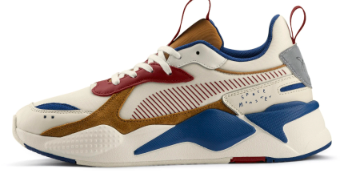

In [5]:
import IPython.display as display
display.display(display.Image(all_image_paths[0]))

In [6]:
def perprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0
    return image

In [7]:
all_images = [perprocess_image(x) for x in all_image_paths]
print(type(all_images))

<class 'list'>


In [8]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [9]:
image_ds = path_ds.map(perprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
print(image_ds)

<ParallelMapDataset shapes: (224, 224, 3), types: tf.float32>


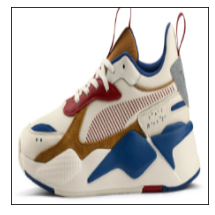

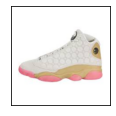

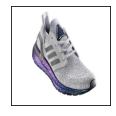

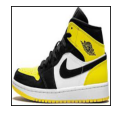

In [10]:
plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [11]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [12]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [13]:
BATCH_SIZE = 32

ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [14]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [15]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
mobile_net.trainable=False

In [16]:
def change_range(image,label):
  return 2*image-1, label
  
keras_ds = ds.map(change_range)

In [17]:
image_batch, label_batch = next(iter(keras_ds))
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 1280)


In [18]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

In [19]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.00820981
max logit: 0.38539582

Shape: (32, 12)


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [21]:
len(model.trainable_variables)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                15372     
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

8.0

In [23]:
model.fit(ds, epochs=20, steps_per_epoch=8)

Epoch 1/20
8/8 [==============================] - 1s 80ms/step - loss: 2.6297 - accuracy: 0.1211
Epoch 2/20
8/8 [==============================] - 1s 67ms/step - loss: 1.8829 - accuracy: 0.4414
Epoch 3/20
8/8 [==============================] - 0s 60ms/step - loss: 1.3334 - accuracy: 0.7109
Epoch 4/20
8/8 [==============================] - 1s 69ms/step - loss: 1.0033 - accuracy: 0.7734
Epoch 5/20
8/8 [==============================] - 1s 63ms/step - loss: 0.7733 - accuracy: 0.8672
Epoch 6/20
8/8 [==============================] - 0s 61ms/step - loss: 0.6263 - accuracy: 0.8984
Epoch 7/20
8/8 [==============================] - 1s 64ms/step - loss: 0.5252 - accuracy: 0.9180
Epoch 8/20
8/8 [==============================] - 1s 64ms/step - loss: 0.4400 - accuracy: 0.9492
Epoch 9/20
8/8 [==============================] - 0s 44ms/step - loss: 0.3809 - accuracy: 0.9531
Epoch 10/20
8/8 [==============================] - 1s 63ms/step - loss: 0.3214 - accuracy: 0.9648
Epoch 11/20
8/8 [============